# Importing

In [1]:
import cv2
import numpy as np
import os

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import gurobipy as gp
from gurobipy import GRB
import math
from itertools import cycle

C:\Users\Cole\anaconda3\envs\generative_classifier\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def find_between(s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

# Optical Flow

In [131]:
# Get a VideoCapture object from video and store it in vс
interpolation = cv2.INTER_AREA
# vc = cv2.VideoCapture("pexels-pixabay-854745-1280x720-50fps.mp4")
vc = cv2.VideoCapture("ball.mp4")
# Read first frame
_, first_frame = vc.read()
# Scale and resize image
resize_dim = 50 # 100
max_dim = max(first_frame.shape)
scale = resize_dim/max_dim
first_frame = cv2.resize(first_frame, None, fx=scale, fy=scale, interpolation = interpolation)
# Convert to gray scale 
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
threshold = 140
prev_gray = np.where(prev_gray>threshold, 1, 0)
print(prev_gray.shape)

(28, 50)


In [132]:
# Create mask
mask = np.zeros_like(first_frame)
# Set image saturation to maximum value as we do not need it
mask[:, :, 1] = 255

In [133]:
out = cv2.VideoWriter("video_of.avi",
cv2.VideoWriter_fourcc(*"MJPG"), 30, (first_frame.shape[1], first_frame.shape[0]))

n_frames = 0
stop_frames = 100
while(vc.isOpened()):
    n_frames += 1
    # Read a frame from video
    ret, frame = vc.read()
    
    # Convert new frame format`s to gray scale and resize gray frame obtained
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=scale, fy=scale, interpolation = interpolation)
#     print(gray.min(), gray.max())
#     plt.imshow(gray)
#     plt.show()
    gray = np.where(gray>threshold, 1, 0)
#     plt.imshow(gray)
#     plt.show()

    # Calculate dense optical flow by Farneback method
    # https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowfarneback
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, pyr_scale = 0.5, levels = 1, winsize = 3, iterations = 5, poly_n = 5, poly_sigma = 1.1, flags = 0)
    # Compute the magnitude and angle of the 2D vectors
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # Set image hue according to the optical flow direction
    mask[..., 0] = angle * 180 / np.pi / 2
    # Set image value according to the optical flow magnitude (normalized)
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    # Convert HSV to RGB (BGR) color representation
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    
    # Resize frame size to match dimensions
    frame = cv2.resize(frame, None, fx=scale, fy=scale, interpolation = interpolation)
    
    # Open a new window and displays the output frame
    dense_flow = cv2.addWeighted(frame, 1,rgb, 2, 0)
    cv2.imshow("Dence optical flow", dense_flow.astype('uint8'))
#     print(dense_flow.shape)
    out.write(dense_flow)
    # Update previous frame
    prev_gray = gray
    # Frame are read by intervals of 1 millisecond. The programs breaks out of the while loop when the user presses the 'q' key
    if (cv2.waitKey(10) & 0xFF == ord('q')) or n_frames == stop_frames:
        break
# The following frees up resources and closes all windows
vc.release()

cv2.destroyAllWindows()
out.release()

# MIP Optimization

In [141]:
def find_between(s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

In [142]:
# Get a VideoCapture object from video and store it in vс
interpolation = cv2.INTER_AREA
# vc = cv2.VideoCapture("pexels-pixabay-854745-1280x720-50fps.mp4")
vc = cv2.VideoCapture("ball.mp4")
# Read first frame
_, first_frame = vc.read()
# Scale and resize image
resize_dim = 50 # 100
max_dim = max(first_frame.shape)
scale = resize_dim/max_dim
first_frame = cv2.resize(first_frame, None, fx=scale, fy=scale, interpolation = interpolation)
# Convert to gray scale 
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
threshold = 140
prev_gray = np.where(prev_gray>threshold, 1, 0)
print(prev_gray.shape)

(28, 50)


In [143]:
image_width, image_height = prev_gray.shape[0], prev_gray.shape[1]
window_size = 1
variable_type = GRB.BINARY # GRB.CONTINUOUS, GRB.INTEGER, GRB.BINARY

In [144]:
class MIP_Model:
    def __init__(self, image_width, image_height, window_size, variable_type, epsilon=0.01):
        self.epsilon = epsilon
        self.image_width = image_width
        self.image_height = image_height
        self.window_size = window_size
        self.variable_type = variable_type
        
        self.m = gp.Model("image_similarity")
        self.m.Params.LogToConsole = 0
        self.m.setParam("Method", 3)

        # initialize pixel shift values
        self.image_shift_values = self.m.addVars(self.image_width, self.image_height, (2*self.window_size+1), (2*self.window_size+1), vtype=self.variable_type, lb=0, ub=1, name="shifts")

        # add constraints that if a pixel shift is outside image, it must be 0
        for x_pixel in range(self.image_width):
            for y_pixel in range(self.image_height):
                for x_shift in range(2*self.window_size+1):
                    for y_shift in range(2*self.window_size+1):
                        if x_pixel + (x_shift - self.window_size) < 0 or x_pixel + (x_shift - self.window_size) > self.image_width-1 or y_pixel + (y_shift - self.window_size) < 0 or y_pixel + (y_shift - self.window_size) > self.image_height-1:
                            self.m.addConstr(self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] == 0)


        # constraints that all source pixels must shift in at least 1 direction
        for x_pixel in range(self.image_width):
            for y_pixel in range(self.image_height):
                self.m.addConstr(gp.quicksum(self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1)) >= 1)

        # constraints that all dest pixels must be mapped to
        for x_pixel in range(self.image_width):
            for y_pixel in range(self.image_height):
                self.m.addConstr(gp.quicksum(self.image_shift_values[x_pixel - (x_shift - self.window_size), y_pixel - (y_shift - self.window_size), x_shift, y_shift] \
                                        for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1) \
                                        if x_pixel - (x_shift - self.window_size) >= 0 and x_pixel - (x_shift - self.window_size) < self.image_width and y_pixel - (y_shift - self.window_size) >= 0 and y_pixel - (y_shift - self.window_size) < self.image_height) \
                            >= 1)
    
        for x_pixel in range(self.image_width):
            for y_pixel in range(self.image_height):
                for x_shift in range(2*self.window_size+1):
                    for y_shift in range(2*self.window_size+1):
                        if y_pixel == 0 and x_pixel == 0:
                            continue
                        elif y_pixel == 0:
                            self.add_left_constraint(x_pixel, y_pixel, x_shift, y_shift)
                        elif x_pixel == 0:
                            self.add_down_constraint(x_pixel, y_pixel, x_shift, y_shift)
                        else:
                            self.add_left_constraint(x_pixel, y_pixel, x_shift, y_shift)
                            self.add_down_constraint(x_pixel, y_pixel, x_shift, y_shift)
                            self.add_down_left_constraint(x_pixel, y_pixel, x_shift, y_shift)
                        if y_pixel != self.image_height-1 and x_pixel != 0:
                            self.add_upleft_constraint(x_pixel, y_pixel, x_shift, y_shift)  

        self.initialize_model_values()
                
                
    def add_left_constraint(self, x_pixel, y_pixel, x_shift, y_shift):
        if x_shift != 2*self.window_size and x_shift != 2*self.window_size-1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"amax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"amax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"amax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel-1, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+2, 2*self.window_size+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)

    def add_down_constraint(self, x_pixel, y_pixel, x_shift, y_shift):
        if y_shift != 2*self.window_size and y_shift != 2*self.window_size-1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"bmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"bmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"bmax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel, y_pixel-1, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift+2, 2*self.window_size+1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)   
            
    def add_down_left_constraint(self, x_pixel, y_pixel, x_shift, y_shift):
        if x_shift != 2*self.window_size and x_shift != 2*self.window_size-1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"cmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"cmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"cmax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel-1, y_pixel-1, xShifts, yShifts] for xShifts in range(x_shift+2, 2*self.window_size+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)
        if y_shift != 2*self.window_size and y_shift != 2*self.window_size-1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"dmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"dmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"dmax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel-1, y_pixel-1, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift+2, 2*self.window_size+1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)      
            
    def add_upleft_constraint(self, x_pixel, y_pixel, x_shift, y_shift):
        if x_shift != 2*self.window_size and x_shift != 2*self.window_size-1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"emax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"emax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"emax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel-1, y_pixel+1, xShifts, yShifts] for xShifts in range(x_shift+2, 2*self.window_size+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)
        if y_shift != 0 and y_shift != 1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"fmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"fmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"fmax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift, 2*self.window_size+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel-1, y_pixel+1, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift-1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)
            
    def initialize_model_values(self):
        for x_pixel in range(self.image_width):
            for y_pixel in range(self.image_height):
                for x_shift in range(2*self.window_size+1):
                    for y_shift in range(2*self.window_size+1):
                        if x_shift == self.window_size and y_shift == self.window_size:
                            self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift].start = 1
                        else:
                            self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift].start = 0
            
            
    def get_similarity(self, img1, img2, verbose=False):
        if verbose:
            self.m.Params.LogToConsole = 1
        else:
            self.m.Params.LogToConsole = 0

        # set objective function
        self.m.setObjective(gp.quicksum(((img1[x_pixel, y_pixel] - img2[x_pixel + (x_shift - self.window_size), y_pixel + (y_shift - self.window_size)]).item() ** 2) * self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_pixel in range(self.image_width) for y_pixel in range(self.image_height) for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1) if x_pixel + (x_shift - self.window_size) >= 0 and x_pixel + (x_shift - self.window_size) <= self.image_width-1 and y_pixel + (y_shift - self.window_size) >= 0 and y_pixel + (y_shift - self.window_size) <= self.image_height-1)\
                       + (gp.quicksum(3*self.epsilon * self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_pixel in range(self.image_width) for y_pixel in range(self.image_height) for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1) if x_shift - self.window_size != 0 or y_shift - self.window_size != 0)) \
                       + (gp.quicksum(self.epsilon * self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_pixel in range(self.image_width) for y_pixel in range(self.image_height) for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1) if x_shift - self.window_size == 0 and y_shift - self.window_size == 0)), GRB.MINIMIZE)
        
#         self.m.setObjective(gp.quicksum(((img1[x_pixel, y_pixel] - img2[x_pixel + (x_shift - self.window_size), y_pixel + (y_shift - self.window_size)]).item() ** 2) * self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_pixel in range(self.image_width) for y_pixel in range(self.image_height) for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1) if x_pixel + (x_shift - self.window_size) >= 0 and x_pixel + (x_shift - self.window_size) <= self.image_width-1 and y_pixel + (y_shift - self.window_size) >= 0 and y_pixel + (y_shift - self.window_size) <= self.image_height-1)\
#                        + (self.epsilon*gp.quicksum(self.image_shift_values)), GRB.MINIMIZE)
        
        self.m.optimize() 
        optimal_value = self.m.objVal

        return optimal_value
    
    
    def get_similarity_score(self, image1, image2, verbose=False):
        self.initialize_model_values()
        val1 = self.get_similarity(image1, image2, verbose)
        self.initialize_model_values()
        val2 = self.get_similarity(image2, image1, verbose)
    #     val2 = 0
        if verbose:
            print([val1, val2])
        return max(val1, val2)
            
                

In [145]:
model = MIP_Model(image_width, image_height, window_size, variable_type)

In [146]:
# Create mask
mask = np.zeros_like(first_frame)
# Set image saturation to maximum value as we do not need it
mask[:, :, 1] = 255

In [147]:
out = cv2.VideoWriter("video_opt.avi",
cv2.VideoWriter_fourcc(*"MJPG"), 30, (first_frame.shape[1], first_frame.shape[0]))

n_frames = 0
stop_frames = 100
while(vc.isOpened()):
    n_frames += 1
    # Read a frame from video
    ret, frame = vc.read()
    
    # Convert new frame format`s to gray scale and resize gray frame obtained
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=scale, fy=scale, interpolation = interpolation)
    gray = np.where(gray>threshold, 1, 0)

    # Calculate dense optical flow by Farneback method
    val = model.get_similarity(prev_gray, gray)
    shift_vals = model.m.getVars()
    flow = np.zeros([gray.shape[0], gray.shape[1], 2])
    for val in shift_vals:
        if "shifts" not in val.VarName:
            continue
        if val.X == 1:
            index = find_between(val.VarName, "[", "]").split(",")
            flow[int(index[0]), int(index[1]), 0] = int(index[2]) - window_size
            flow[int(index[0]), int(index[1]), 0] = int(index[3]) - window_size
#     flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, pyr_scale = 0.5, levels = 1, winsize = 3, iterations = 5, poly_n = 5, poly_sigma = 1.1, flags = 0)
    # Compute the magnitude and angle of the 2D vectors
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # Set image hue according to the optical flow direction
    mask[..., 0] = angle * 180 / np.pi / 2
    # Set image value according to the optical flow magnitude (normalized)
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    # Convert HSV to RGB (BGR) color representation
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    
    # Resize frame size to match dimensions
    frame = cv2.resize(frame, None, fx=scale, fy=scale, interpolation = interpolation)
    
    # Open a new window and displays the output frame
    dense_flow = cv2.addWeighted(frame, 1,rgb, 2, 0)
    cv2.imshow("Dence optical flow", dense_flow.astype('uint8'))
#     print(dense_flow.shape)
    out.write(dense_flow)
    # Update previous frame
    prev_gray = gray
    # Frame are read by intervals of 1 millisecond. The programs breaks out of the while loop when the user presses the 'q' key
    if (cv2.waitKey(10) & 0xFF == ord('q')) or n_frames == stop_frames:
        break
# The following frees up resources and closes all windows
vc.release()

cv2.destroyAllWindows()
out.release()

In [149]:
# Get a VideoCapture object from video and store it in vс
interpolation = cv2.INTER_AREA
# vc = cv2.VideoCapture("pexels-pixabay-854745-1280x720-50fps.mp4")
vc = cv2.VideoCapture("ball.mp4")
# Read first frame
_, first_frame = vc.read()
# Scale and resize image
resize_dim = 50 # 100
max_dim = max(first_frame.shape)
scale = resize_dim/max_dim
first_frame = cv2.resize(first_frame, None, fx=scale, fy=scale, interpolation = interpolation)
# Convert to gray scale 
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
threshold = 140
prev_gray = np.where(prev_gray>threshold, 1, 0)
print(prev_gray.shape)

(28, 50)


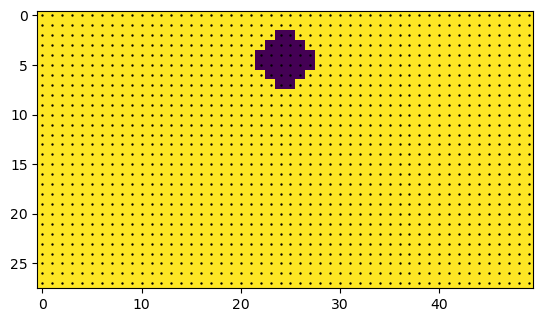

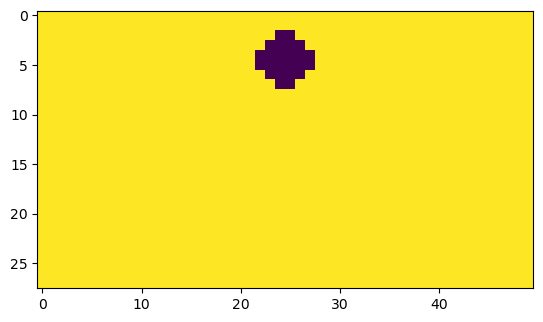

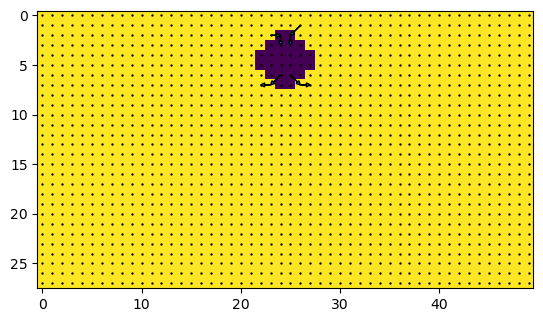

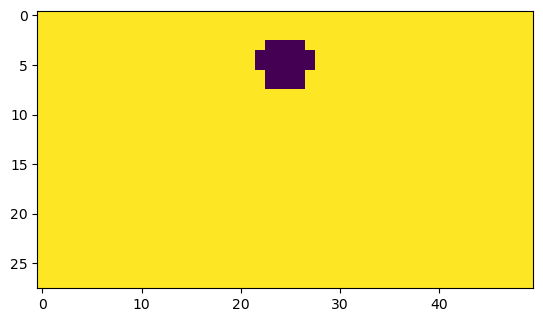

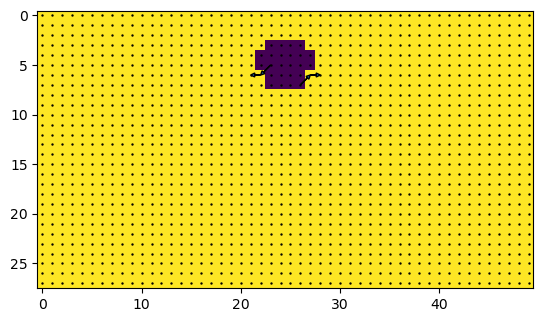

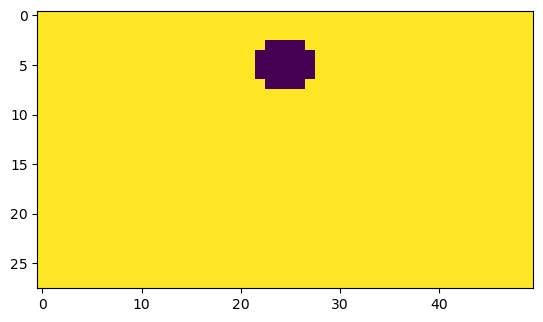

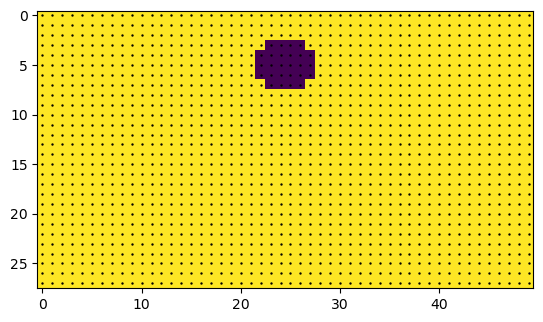

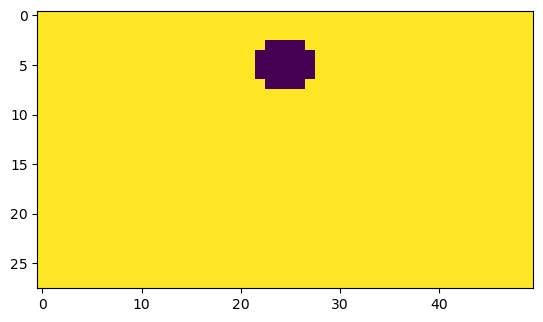

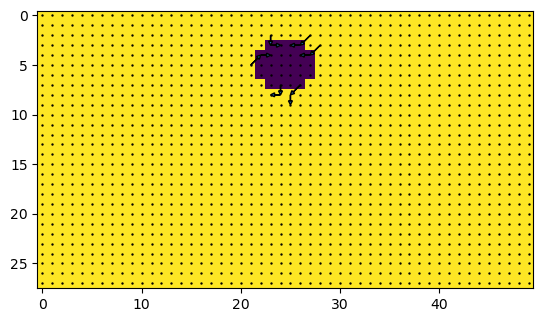

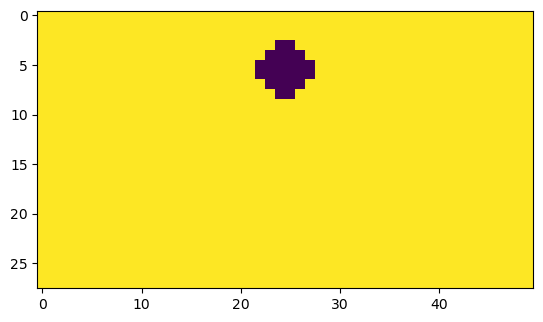

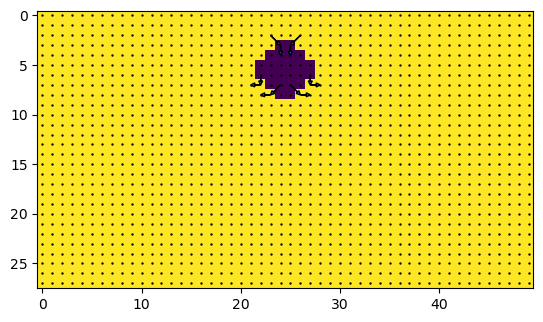

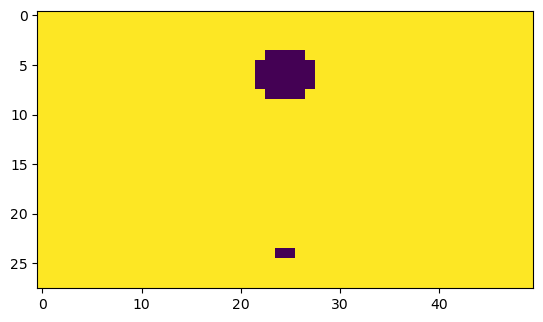

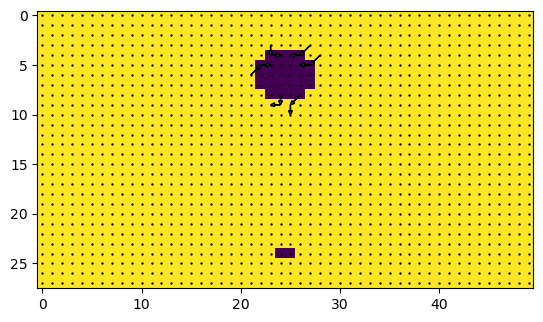

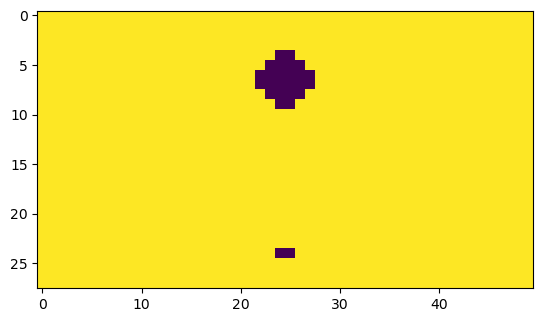

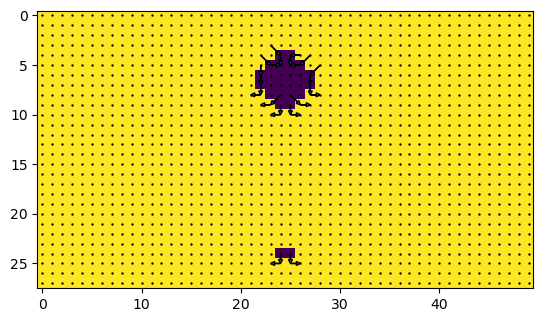

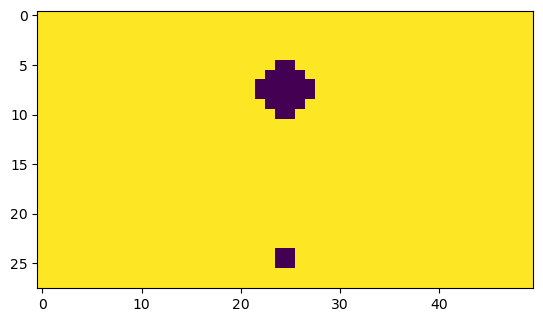

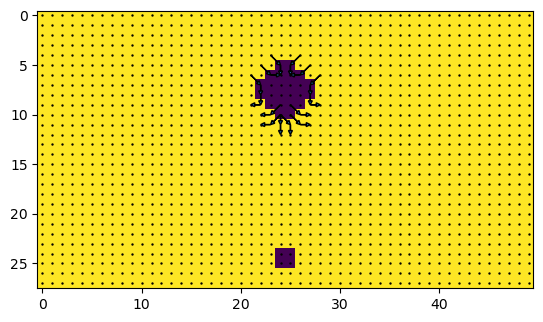

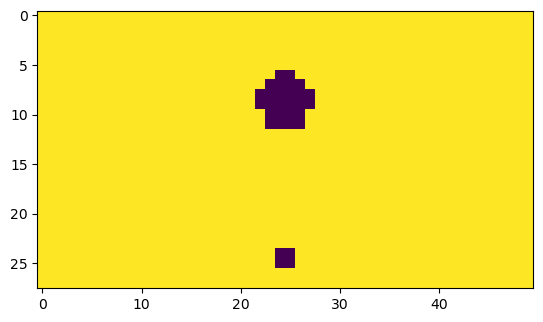

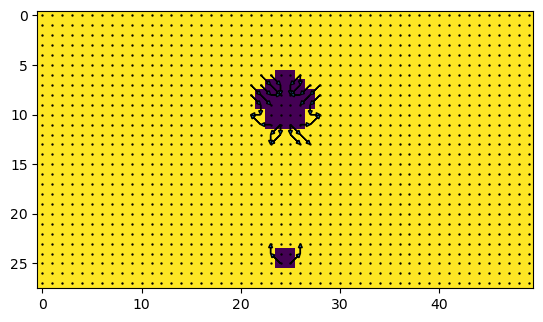

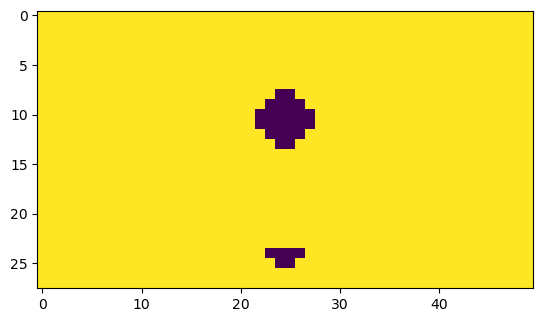

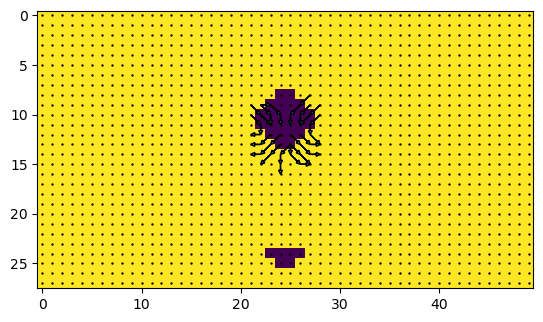

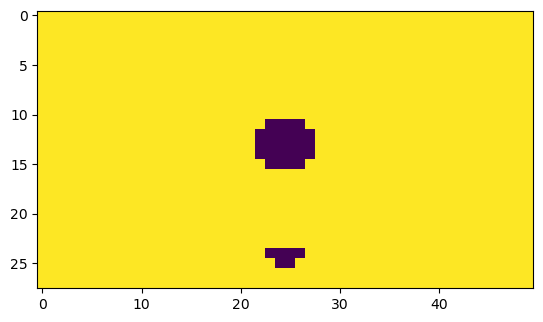

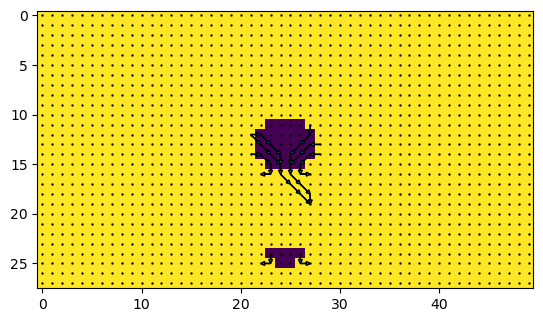

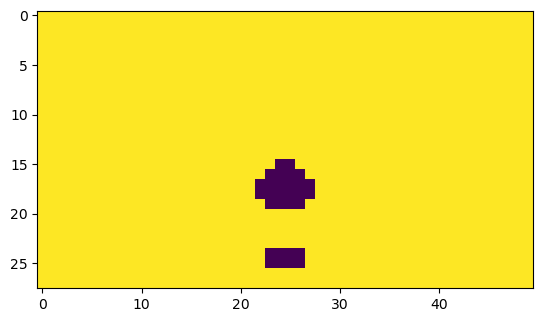

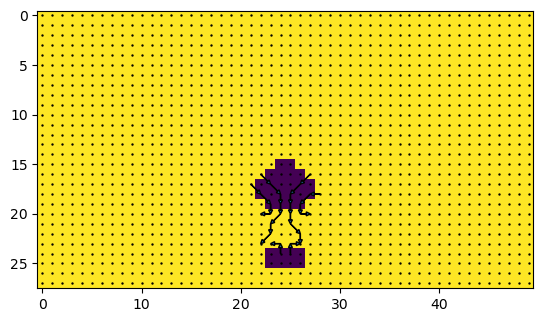

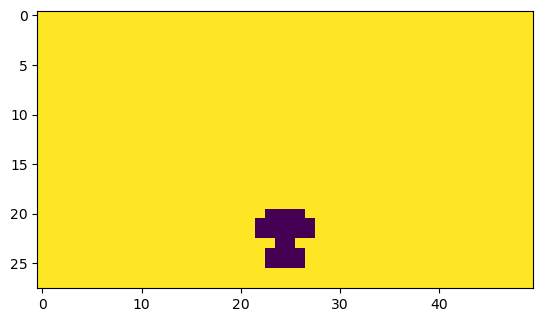

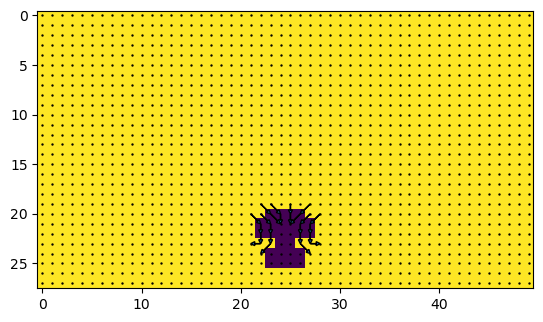

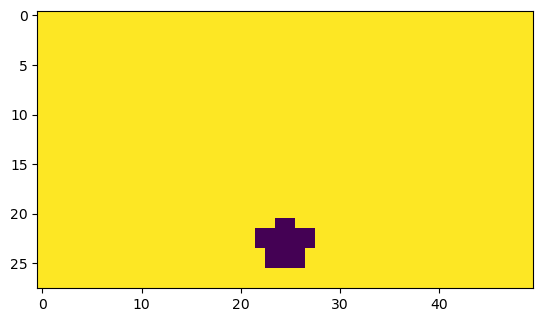


KeyboardInterrupt



In [150]:
n_frames = 0
stop_frames = 20
while(vc.isOpened()):
    n_frames += 1
    # Read a frame from video
    ret, frame = vc.read()
    
    # Convert new frame format`s to gray scale and resize gray frame obtained
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=scale, fy=scale, interpolation = interpolation)
    gray = np.where(gray>threshold, 1, 0)

    # Calculate dense optical flow by Farneback method
    val = model.get_similarity(prev_gray, gray)
    shift_vals = model.m.getVars()
    
    plt.imshow(prev_gray)
    for val in shift_vals:
        if val.X == 1:
            index = find_between(val.VarName, "[", "]").split(",")
            if "shifts" not in val.VarName:
                continue
            if int(index[3])-window_size == 0 and int(index[2])-window_size == 0:
                plt.scatter(int(index[1]), int(index[0]), c="black", s=0.5)
            else:
                plt.arrow(int(index[1]), int(index[0]), int(index[3])-window_size, int(index[2])-window_size, length_includes_head=True, head_width=0.4, head_length=0.4)
#             plt.arrow(int(index[1]), int(index[0]), 1, 1)
#             print(index)
    plt.show()
    plt.imshow(gray)
    plt.show()



    # Update previous frame
    prev_gray = gray
    # Frame are read by intervals of 1 millisecond. The programs breaks out of the while loop when the user presses the 'q' key
    if (cv2.waitKey(10) & 0xFF == ord('q')) or n_frames == stop_frames:
        break
# The following frees up resources and closes all windows
vc.release()

cv2.destroyAllWindows()

# Box Movement MIP Optimization

In [4]:
def expand_objects(img):
    next_img = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if np.sum(img[max(0, i-1):min(i+2, img.shape[0]), max(0, j-1):min(j+2, img.shape[1])]) > 0:
                next_img[i, j] = 1
    return next_img     

In [5]:
def place_square(img_hw, sq_hw, sq_bottom_left):
    img = np.zeros([img_hw, img_hw])
    img[sq_bottom_left[0]:sq_bottom_left[0]+sq_hw, sq_bottom_left[1]:sq_bottom_left[1]+sq_hw] = 1
    return img     

In [6]:
def calculate_shift_diff(shift1, shift2):
    shift_diff = math.sqrt((shift1[0] - shift2[0]) ** 2 + (shift1[1] - shift2[1]) ** 2)
    return shift_diff

In [81]:
class MIP_Model:
    def __init__(self, image_width, image_height, window_size, shift_diff_window_size, variable_type, epsilon=0.01):
        self.epsilon = epsilon
        self.image_width = image_width
        self.image_height = image_height
        self.window_size = window_size
        self.shift_diff_window_size = shift_diff_window_size
        self.variable_type = variable_type
        
        self.m = gp.Model("image_similarity")
        self.m.Params.LogToConsole = 0
        self.m.setParam("Method", 3)

        # initialize pixel shift values
        self.image_shift_values = self.m.addVars(self.image_width, self.image_height, (2*self.window_size+1), (2*self.window_size+1), vtype=self.variable_type, lb=0, ub=1, name="shifts")

        # add constraints that if a pixel shift is outside image, it must be 0
        for x_pixel in range(self.image_width):
            for y_pixel in range(self.image_height):
                for x_shift in range(2*self.window_size+1):
                    for y_shift in range(2*self.window_size+1):
                        if x_pixel + (x_shift - self.window_size) < 0 or x_pixel + (x_shift - self.window_size) > self.image_width-1 or y_pixel + (y_shift - self.window_size) < 0 or y_pixel + (y_shift - self.window_size) > self.image_height-1:
                            self.m.addConstr(self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] == 0)


        # constraints that all source pixels must shift in at least 1 direction
        for x_pixel in range(self.image_width):
            for y_pixel in range(self.image_height):
                self.m.addConstr(gp.quicksum(self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1)) >= 1)

        # constraints that all dest pixels must be mapped to
        for x_pixel in range(self.image_width):
            for y_pixel in range(self.image_height):
                self.m.addConstr(gp.quicksum(self.image_shift_values[x_pixel - (x_shift - self.window_size), y_pixel - (y_shift - self.window_size), x_shift, y_shift] \
                                        for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1) \
                                        if x_pixel - (x_shift - self.window_size) >= 0 and x_pixel - (x_shift - self.window_size) < self.image_width and y_pixel - (y_shift - self.window_size) >= 0 and y_pixel - (y_shift - self.window_size) < self.image_height) \
                            >= 1)
    
        for x_pixel in range(self.image_width):
            for y_pixel in range(self.image_height):
                for x_shift in range(2*self.window_size+1):
                    for y_shift in range(2*self.window_size+1):
                        self.add_no_part_constraint(x_pixel, y_pixel, x_shift, y_shift)
                        if y_pixel == 0 and x_pixel == 0:
                            continue
                        elif y_pixel == 0:
                            self.add_left_constraint(x_pixel, y_pixel, x_shift, y_shift)
                        elif x_pixel == 0:
                            self.add_down_constraint(x_pixel, y_pixel, x_shift, y_shift)
                        else:
                            self.add_left_constraint(x_pixel, y_pixel, x_shift, y_shift)
                            self.add_down_constraint(x_pixel, y_pixel, x_shift, y_shift)
                            self.add_down_left_constraint(x_pixel, y_pixel, x_shift, y_shift)
                        if y_pixel != self.image_height-1 and x_pixel != 0:
                            self.add_up_left_constraint(x_pixel, y_pixel, x_shift, y_shift)  

        self.initialize_model_values()
                
                
    def add_left_constraint(self, x_pixel, y_pixel, x_shift, y_shift):
        if x_shift != 2*self.window_size and x_shift != 2*self.window_size-1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"amax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"amax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"amax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel-1, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+2, 2*self.window_size+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)

    def add_down_constraint(self, x_pixel, y_pixel, x_shift, y_shift):
        if y_shift != 2*self.window_size and y_shift != 2*self.window_size-1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"bmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"bmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"bmax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel, y_pixel-1, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift+2, 2*self.window_size+1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)   
            
    def add_down_left_constraint(self, x_pixel, y_pixel, x_shift, y_shift):
        if x_shift != 2*self.window_size and x_shift != 2*self.window_size-1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"cmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"cmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"cmax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel-1, y_pixel-1, xShifts, yShifts] for xShifts in range(x_shift+2, 2*self.window_size+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)
        if y_shift != 2*self.window_size and y_shift != 2*self.window_size-1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"dmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"dmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"dmax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel-1, y_pixel-1, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift+2, 2*self.window_size+1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)      
            
    def add_up_left_constraint(self, x_pixel, y_pixel, x_shift, y_shift):
        if x_shift != 2*self.window_size and x_shift != 2*self.window_size-1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"emax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"emax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"emax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel-1, y_pixel+1, xShifts, yShifts] for xShifts in range(x_shift+2, 2*self.window_size+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)
        if y_shift != 0 and y_shift != 1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"fmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"fmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"fmax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift, 2*self.window_size+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel-1, y_pixel+1, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift-1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)
            
            
    def add_no_part_constraint(self, x_pixel, y_pixel, x_shift, y_shift):
        for x_neighbor in range(max(0, x_pixel-1), min(self.image_width, x_pixel+2)): 
            for y_neighbor in range(max(0, y_pixel-1), min(self.image_height, y_pixel+2)):
                if x_neighbor == x_pixel and y_neighbor == y_pixel:
                    continue
                sum_of_neighbor_pixel_shifts = gp.quicksum(self.image_shift_values[x_neighbor, y_neighbor, xShifts, yShifts] \
                                                                for xShifts in range(max(0, x_shift-1), min(2*self.window_size+1, x_shift+2)) for yShifts in range(max(0, y_shift-1), min(2*self.window_size+1, y_shift+2)))
        
        
                self.m.addConstr(self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] <= sum_of_neighbor_pixel_shifts)
            
            
            
    def initialize_model_values(self):
        for x_pixel in range(self.image_width):
            for y_pixel in range(self.image_height):
                for x_shift in range(2*self.window_size+1):
                    for y_shift in range(2*self.window_size+1):
                        if x_shift == self.window_size and y_shift == self.window_size:
                            self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift].start = 1
                        else:
                            self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift].start = 0
            
            
    def get_similarity(self, img1, img2, verbose=False):
        if verbose:
            self.m.Params.LogToConsole = 1
        else:
            self.m.Params.LogToConsole = 0

        # set objective function
        self.m.setObjective(gp.quicksum(((img1[x_pixel, y_pixel] - img2[x_pixel + (x_shift - self.window_size), y_pixel + (y_shift - self.window_size)]).item() ** 2) * self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_pixel in range(self.image_width) for y_pixel in range(self.image_height) for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1) if x_pixel + (x_shift - self.window_size) >= 0 and x_pixel + (x_shift - self.window_size) <= self.image_width-1 and y_pixel + (y_shift - self.window_size) >= 0 and y_pixel + (y_shift - self.window_size) <= self.image_height-1)\
                       + (gp.quicksum(10*self.epsilon * self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_pixel in range(self.image_width) for y_pixel in range(self.image_height) for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1) if x_shift - self.window_size != 0 or y_shift - self.window_size != 0)) \
                       + (gp.quicksum(self.epsilon * self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_pixel in range(self.image_width) for y_pixel in range(self.image_height) for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1) if x_shift - self.window_size == 0 and y_shift - self.window_size == 0)), GRB.MINIMIZE)
        
#         self.m.setObjective(gp.quicksum(((img1[x_pixel, y_pixel] - img2[x_pixel + (x_shift - self.window_size), y_pixel + (y_shift - self.window_size)]).item() ** 2) * self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_pixel in range(self.image_width) for y_pixel in range(self.image_height) for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1) if x_pixel + (x_shift - self.window_size) >= 0 and x_pixel + (x_shift - self.window_size) <= self.image_width-1 and y_pixel + (y_shift - self.window_size) >= 0 and y_pixel + (y_shift - self.window_size) <= self.image_height-1)\
#                        + (self.epsilon*gp.quicksum(self.image_shift_values)), GRB.MINIMIZE)
        
        self.m.optimize() 
        optimal_value = self.m.objVal

        return optimal_value
    
    
    def get_similarity_score(self, image1, image2, verbose=False):
        self.initialize_model_values()
        val1 = self.get_similarity(image1, image2, verbose)
        self.initialize_model_values()
        val2 = self.get_similarity(image2, image1, verbose)
    #     val2 = 0
        if verbose:
            print([val1, val2])
        return max(val1, val2)

In [82]:
prev_gray = np.zeros([20, 20])
gray = np.zeros([20, 20])

prev_gray[8:12, 8:12] = 1
gray[8:12, 9:13] = 1

In [83]:
image_width, image_height = prev_gray.shape[0], prev_gray.shape[1]
window_size = 1
variable_type = GRB.BINARY # GRB.CONTINUOUS, GRB.INTEGER, GRB.BINARY

In [84]:
model = MIP_Model(image_width, image_height, window_size, 0, variable_type, epsilon=0.0001)

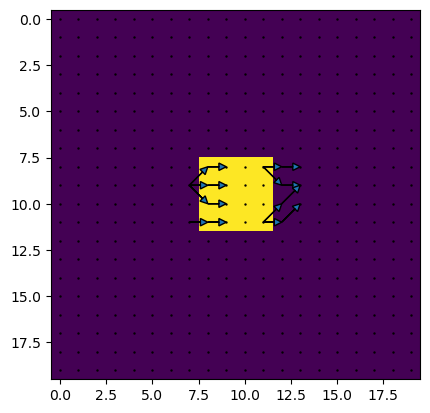

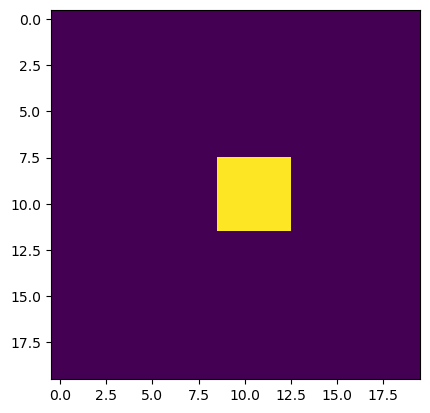

In [85]:
val = model.get_similarity(prev_gray, gray, False)
shift_vals = model.m.getVars()


plt.imshow(prev_gray)
for val in shift_vals:
    if val.X == 1:
        index = find_between(val.VarName, "[", "]").split(",")
        if "shifts" not in val.VarName:
            continue
        if int(index[3])-window_size == 0 and int(index[2])-window_size == 0:
            plt.scatter(int(index[1]), int(index[0]), c="black", s=0.5)
        else:
            plt.arrow(int(index[1]), int(index[0]), int(index[3])-window_size, int(index[2])-window_size, length_includes_head=True, head_width=0.4, head_length=0.4)
#             plt.arrow(int(index[1]), int(index[0]), 1, 1)
#             print(index)
plt.show()
plt.imshow(gray)
plt.show()

# Expansion

In [93]:
prev_gray = np.zeros([20, 20])
prev_gray[10, 10] = 1

In [94]:
image_width, image_height = prev_gray.shape[0], prev_gray.shape[1]
window_size = 1
variable_type = GRB.BINARY # GRB.CONTINUOUS, GRB.INTEGER, GRB.BINARY

In [95]:
model = MIP_Model(image_width, image_height, window_size, 0, variable_type, epsilon=0.000001)

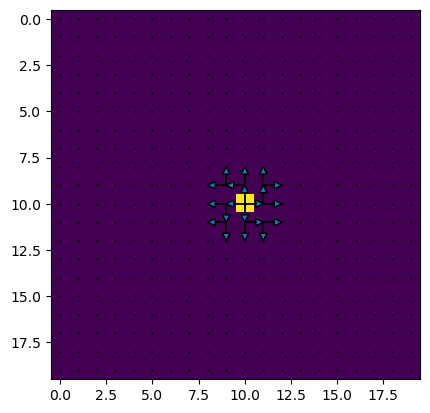

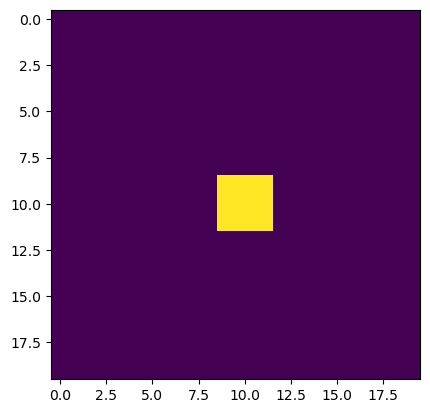

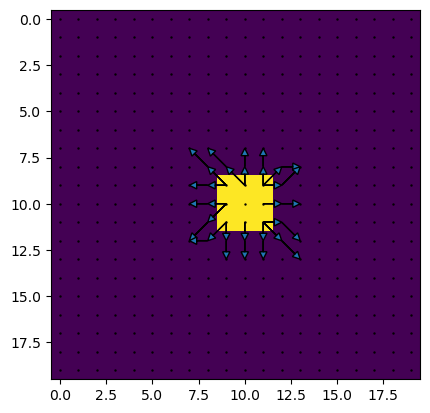

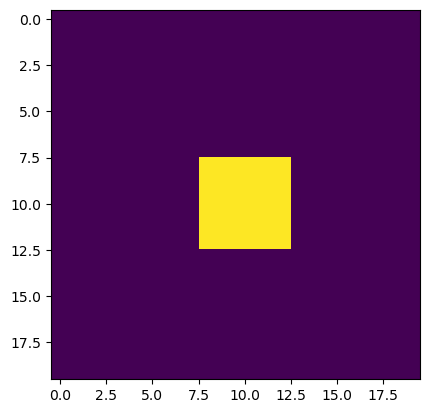

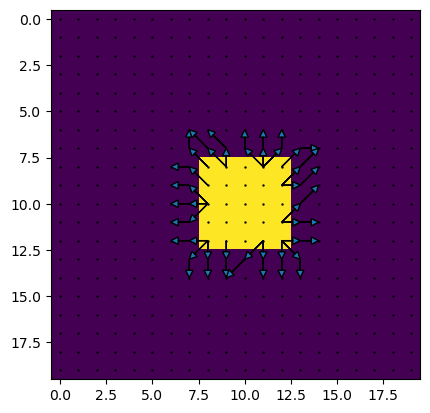

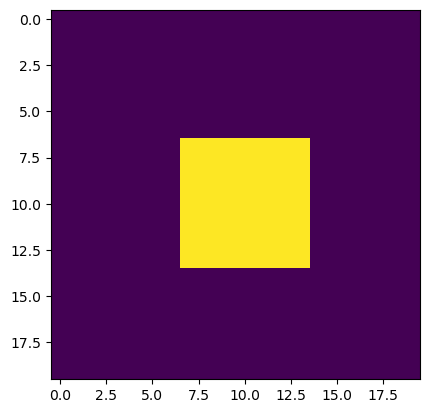

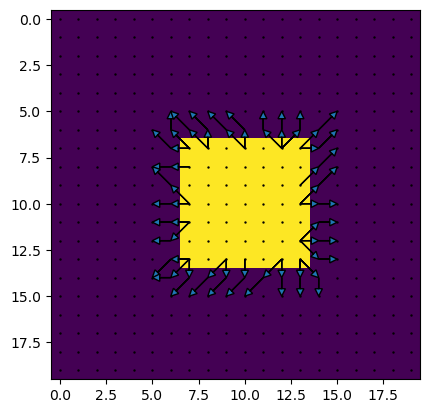

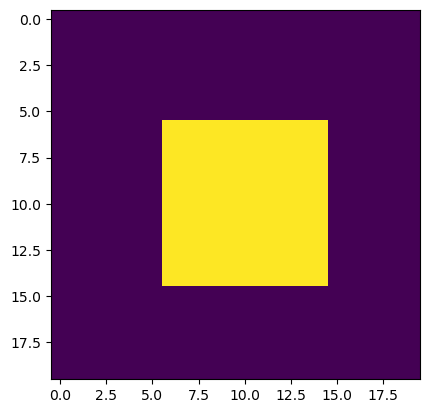

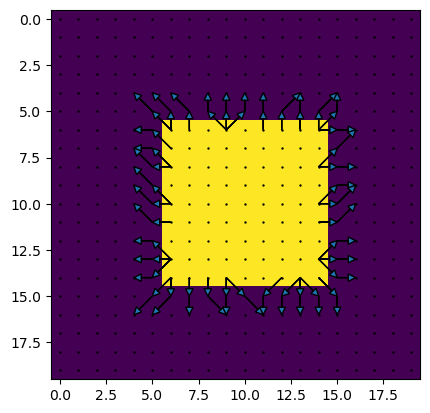

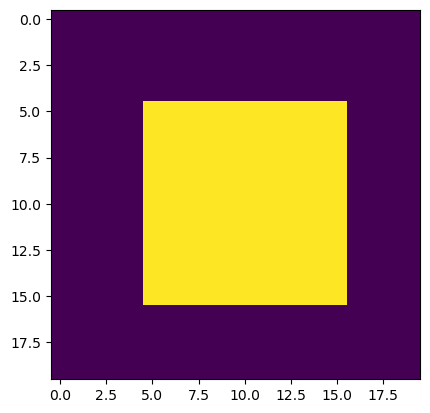

In [96]:
n_frames = 5
for frame in range(n_frames):
    gray = expand_objects(prev_gray)

    # Calculate dense optical flow by Farneback method
    val = model.get_similarity(prev_gray, gray, False)
    shift_vals = model.m.getVars()

    plt.imshow(prev_gray)
    for val in shift_vals:
        if val.X == 1:
            index = find_between(val.VarName, "[", "]").split(",")
            if "shifts" not in val.VarName:
                continue
            if int(index[3])-window_size == 0 and int(index[2])-window_size == 0:
                plt.scatter(int(index[1]), int(index[0]), c="black", s=0.5)
            else:
                plt.arrow(int(index[1]), int(index[0]), int(index[3])-window_size, int(index[2])-window_size, length_includes_head=True, head_width=0.4, head_length=0.4)
#             plt.arrow(int(index[1]), int(index[0]), 1, 1)
#             print(index)
    plt.show()
    plt.imshow(gray)
    plt.show()


    # Update previous frame
    prev_gray = gray

In [97]:
image_width, image_height = 10, 10
window_size = 1
variable_type = GRB.BINARY # GRB.CONTINUOUS, GRB.INTEGER, GRB.BINARY

In [100]:
model = MIP_Model(image_width, image_height, window_size, 0, variable_type, epsilon=0.0001)

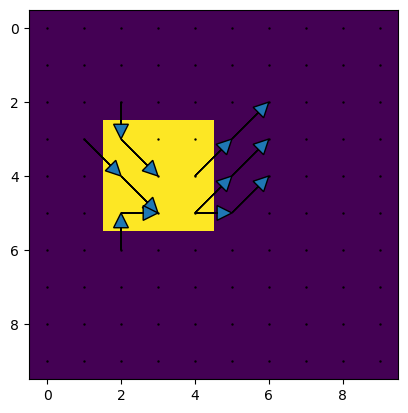

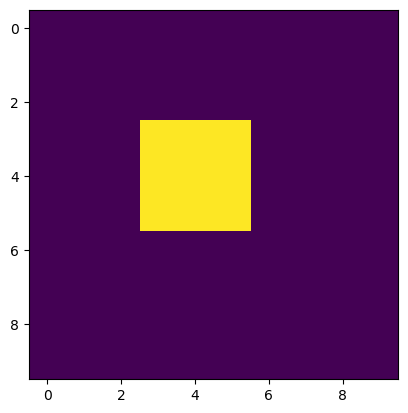

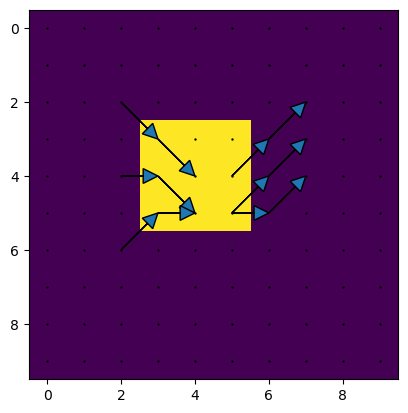

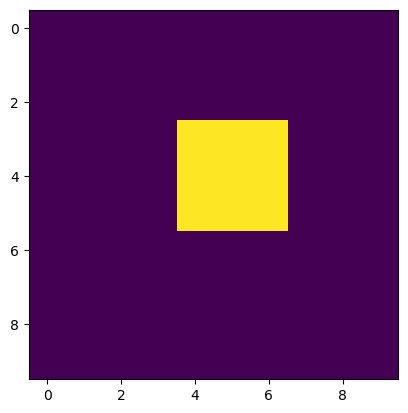

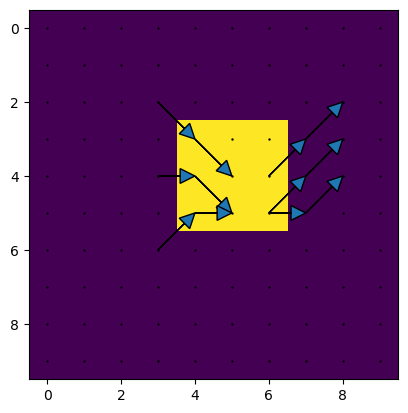

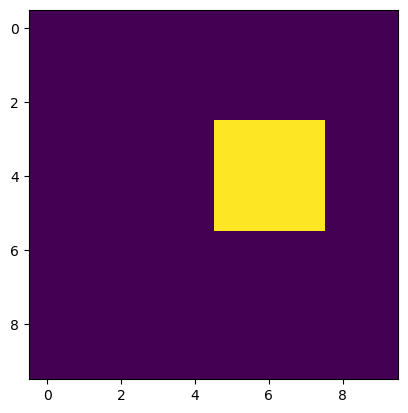

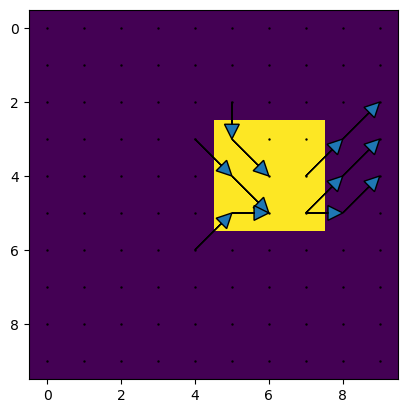

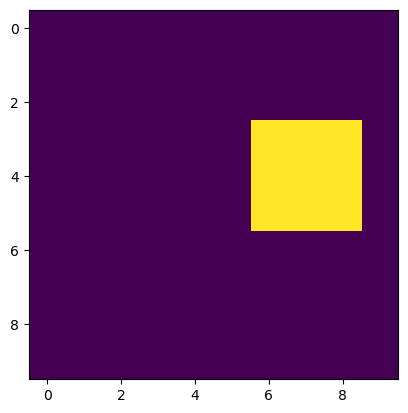

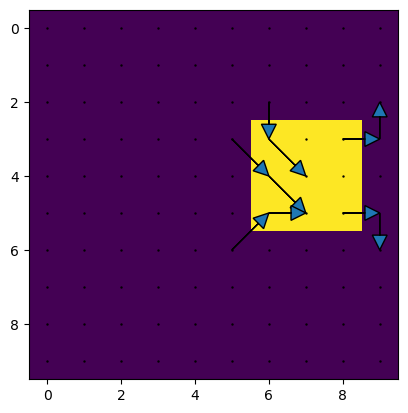

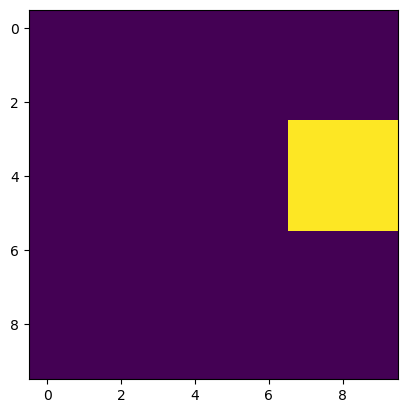

In [101]:
n_frames = 5
prev_gray = place_square(10, 3, [3, 2])
for frame in range(n_frames):
    gray = place_square(10, 3, [3, 3+frame])

    # Calculate dense optical flow by Farneback method
    val = model.get_similarity(prev_gray, gray, False)
    shift_vals = model.m.getVars()

    plt.imshow(prev_gray)
    for val in shift_vals:
        if val.X == 1:
            index = find_between(val.VarName, "[", "]").split(",")
            if "shifts" not in val.VarName:
                continue
            if int(index[3])-window_size == 0 and int(index[2])-window_size == 0:
                plt.scatter(int(index[1]), int(index[0]), c="black", s=0.5)
            else:
                plt.arrow(int(index[1]), int(index[0]), int(index[3])-window_size, int(index[2])-window_size, length_includes_head=True, head_width=0.4, head_length=0.4)
#             plt.arrow(int(index[1]), int(index[0]), 1, 1)
#             print(index)
    plt.show()
    plt.imshow(gray)
    plt.show()


    # Update previous frame
    prev_gray = gray